# Transfer Model 3
Simplify model structure of T1 further, and utilize FTRL which is optimized for shallow models.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import scipy
import scipy.stats

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2022-08-19 17:29:34.306228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-19 17:29:34.306252: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


In [3]:
from sklearn import linear_model
import sklearn.metrics

In [4]:
import Training

`N_CPUS` is the number of CPU cores to use for training. **Do not use more than half your physically installed cores.** Tensorflow appears to struggle with some race conditions if there are too many contesting threads; it doesn't crash and it doesn't skew the results, but it does complain of "excessive graph retracing".

In [5]:
N_CPUS = 2
iterations = 10

In [ ]:
tf.config.set_logical_device_configuration(
    tf.config.list_physical_devices('CPU')[0],
    [tf.config.LogicalDeviceConfiguration() for n in range(N_CPUS)]
)

## Load Data

In [7]:
featFileName = "../data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)

In [8]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']
bat_info

,policy,barcode,cycle_life
0,3_6C-80PER_3_6C,???,1189.0
1,3_6C-80PER_3_6C,???,1178.0
2,3_6C-80PER_3_6C,???,1176.0
3,4C-80PER_4C,???,1225.0
4,4C-80PER_4C,???,1226.0
...,...,...,...
75,6C_31PER_4_25C,???,462.0
76,6C_40PER_4C,???,457.0
77,6C_4PER_4_75C,???,487.0
78,6C_52PER_3_5C,???,429.0


In [9]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.071,  0.468,  1.076, ...,  1.091,  0.   ,  1.072],
       [ 1.075,  0.009,  1.081, ...,  1.081, -0.   ,  1.085],
       [ 1.08 ,  0.008,  1.085, ...,  1.085, -0.   ,  1.089],
       ...,
       [ 1.07 ,  0.005,  1.073, ...,  1.075, -0.   ,  1.081],
       [ 1.073,  0.007,  1.08 , ...,  1.078, -0.   ,  1.081],
       [ 1.042,  0.008,  1.047, ...,  1.049, -0.   ,  1.055]])

In [10]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

### Data Split
fast-normal charging split and then train-test split

In [11]:
fast_charge_indices = bat_info['policy'].str.match("^[5-8].*C")
slow_charge_feat = feat[~fast_charge_indices]
slow_charge_label = bat_info["cycle_life"][~fast_charge_indices]
fast_charge_feat = feat[fast_charge_indices]
fast_charge_label = bat_info["cycle_life"][fast_charge_indices]

In [12]:
feat_train = slow_charge_feat[0::2]
feat_test = slow_charge_feat[1::2]
label_train = slow_charge_label[0::2]
label_test = slow_charge_label[1::2]

In [13]:
# scale data
feat_train_scaled = scipy.stats.zscore(feat_train)
feat_test_scaled = scipy.stats.zmap(feat_test, feat_train)

## Load Base Model
Load the 'base' model trained on 'fast charging' data subset.

In [14]:
def load_base_model():
    model = keras.models.load_model('../discharge_model/saved_model/DischargeModelFastTF')
    return model

In [15]:
discharge_model_fast = load_base_model()
discharge_model_fast.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [55]:
# RMSE of fast-charge base model on normal-charge test set
discharge_model_fast.evaluate(
    feat_test_scaled,
    label_test,
    verbose=0
) ** 0.5

170.57145451027262

## Model Building
Custom layer that performs a single n-feature element-wise multiply instead of utilizing 13 nodes with individual dot product.

In [29]:
class FusedMultiplyAdd(layers.Layer):
    def __init__(self,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        kernel_regularizer=None
    ) -> None:
        super(FusedMultiplyAdd, self).__init__()
        self.kernel_init = kernel_initializer
        self.bias_init = bias_initializer
        self.kernel_reg=kernel_regularizer
    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
            shape=(input_shape[-1],),
            initializer=self.kernel_init,
            regularizer=self.kernel_reg,
            trainable=True)
        self.bias = self.add_weight("bias",
            shape=(input_shape[-1],),
            initializer=self.bias_init,
            trainable=True)
    def call(self, inputs):
        return tf.add(
            tf.multiply(inputs, self.kernel),
            self.bias
        )

In [17]:
def make_FTRL_transfer_model():
    base_model = load_base_model()
    base_model.trainable = False

    transfer_model = keras.models.Sequential([
        FusedMultiplyAdd(kernel_initializer='ones'),
        base_model
    ])
    
    # Initialize layer shape to match training batch size
    transfer_model(feat_train_scaled)

    transfer_model.compile(
        optimizer=keras.optimizers.Ftrl(
            learning_rate=0.0001,
            learning_rate_power=-0.1,
            l1_regularization_strength=0.9,
            l2_regularization_strength=0.1
        ),
        loss='mean_squared_error')
    
    return transfer_model

In [41]:
def make_ADAM_transfer_model():
    base_model = load_base_model()
    base_model.trainable = False

    transfer_model = keras.models.Sequential([
        FusedMultiplyAdd(kernel_initializer='ones'),
        base_model
    ])
    
    # Initialize layer shape to match training batch size
    transfer_model(feat_train_scaled)

    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0002),
        loss='mean_squared_error')
    
    return transfer_model

## Train Models
Note: All models are using early-stopping

In [19]:
cpus = [device.name for device in tf.config.list_logical_devices()]

In [47]:
results1 = Training.multithread_train(
    feat_train_scaled,
    label_train,
    feat_test_scaled,
    label_test,
    make_FTRL_transfer_model,
    device_list=np.resize(cpus, 10),
    epochs=1000,
    num_threads=len(cpus)
)

Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:0
Training on /device:CPU:1


In [42]:
results2 = Training.multithread_train(
    feat_train_scaled,
    label_train,
    feat_test_scaled,
    label_test,
    make_ADAM_transfer_model,
    device_list=np.resize(cpus, 10),
    epochs=1000,
    num_threads=len(cpus)
)

Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:0
Training on /device:CPU:1


## Evaluate Models

### TensorFlow Per-Run RMSE

In [48]:
FTRL_RMSE = pd.DataFrame(results1)
ADAM_RMSE = pd.DataFrame(results2)

In [49]:
all_RMSE = pd.concat([FTRL_RMSE['RMSE'], ADAM_RMSE['RMSE']], axis=1, keys=['FTRL','ADAM'])
all_RMSE

,FTRL,ADAM
0,130.045184,150.016503
1,130.045184,150.016510
2,130.045184,150.016503
3,130.045184,150.016503
4,130.045184,150.016503
5,130.045184,150.016503
6,130.045184,150.016503
7,130.045184,150.016503
8,130.045192,150.016503
9,130.045192,150.016503


In [50]:
RMSE_stats = all_RMSE.describe().transpose().drop(['25%', '50%', '75%'], axis=1)
RMSE_stats

,count,mean,std,min,max
FTRL,10.0,130.045186,0.000003,130.045184,130.045192
ADAM,10.0,150.016504,0.000002,150.016503,150.016510


### Loss Graphs

In [51]:
def plot_loss(history, ylims = [100, 300], ax_names={'loss': 'loss', 'val_loss': 'val_loss'}):
    plt.plot(np.sqrt(history.history['loss']), 'b', label=ax_names['loss'])
    plt.plot(np.sqrt(history.history['val_loss']), 'r', label=ax_names['val_loss'])
    plt.ylim(ylims)
    plt.xlabel('Epoch')
    plt.ylabel('Error [cycles]')
    plt.legend()
    plt.grid(True)
    # plt.show()

Runs of all ten FTRL transfer models overlaid on the same graph

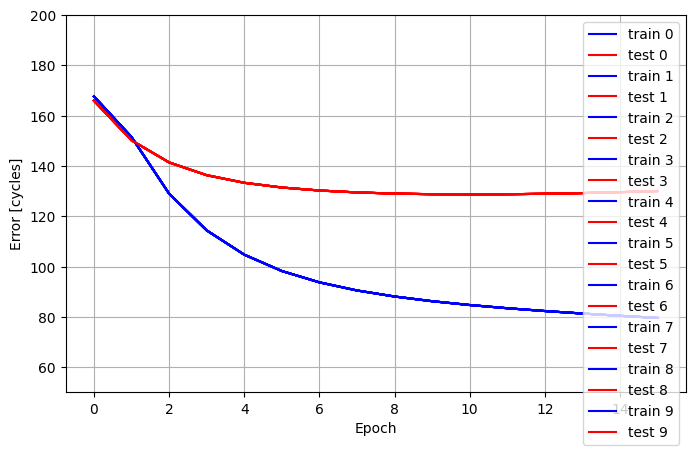

In [52]:
plt.figure('FTRLLoss', figsize=(8,5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(FTRL_RMSE)):
    plot_loss(FTRL_RMSE['history'][i],
        ylims=[50,200],
        ax_names={
            'loss': 'train '+str(i),
            'val_loss': 'test '+str(i)
        })
plt.show()

Runs of all ten ADAM transfer models overlaid on the same graph

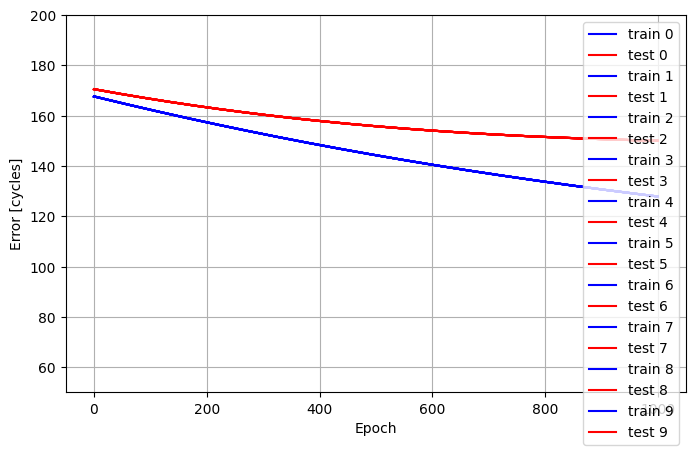

In [53]:
plt.figure('ADAMLoss', figsize=(8,5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(ADAM_RMSE)):
    plot_loss(ADAM_RMSE['history'][i],
        ylims=[50,200],
        ax_names={
            'loss': 'train '+str(i),
            'val_loss': 'test '+str(i)
        })
plt.show()